In [3]:
from functools import partial
from itertools import product
import pandas as pd
from sklearn.pipeline import Pipeline
from friendly_guacamole.transforms import (
    FilterSamples,
    UniFrac,
    RarefactionBIOM,
    PCoA,
    AsDense,
    CLR,
)
from friendly_guacamole.datasets import KeyboardDataset
from umap import UMAP



In [4]:
keyboard_data = KeyboardDataset('data/keyboard')
tree = keyboard_data.apply('tree', 'path')

RAREFACTION_DEPTH = 500

Files already downloaded and verified


In [15]:
min_count_filter = FilterSamples(min_count=RAREFACTION_DEPTH)
kb_mf = keyboard_data['metadata']
kb_table = keyboard_data['table']
kb_mf = kb_mf.set_index('sample_name')
metadata = kb_mf[kb_mf.host_subject_id.isin(['M2','M3', 'M9'])]
kb_table = kb_table.filter(metadata.index)
table = min_count_filter.fit_transform(kb_table)
metadata = metadata.loc[table.ids('sample')]

In [16]:
rarefied_table = RarefactionBIOM(RAREFACTION_DEPTH).fit_transform(table)

In [17]:
def postprocess_umap(results):
    return pd.DataFrame(results, columns=[f'PC{i + 1}'
                                          for i in range(results.shape[1])])

In [18]:
prep_tables = [
    {
        'name': 'Aitchison',
        'metric': 'euclidean',
        'pipeline': Pipeline([
            ('asdense', AsDense()),
            ('clr', CLR()),
        ]),
    },
    {
        'name': 'Bray-Curtis',
        'metric': 'braycurtis',
        'pipeline': AsDense(),
    },
    {
        'name': 'Jaccard',
        'metric': 'jaccard',
        'pipeline': AsDense(),
    },
    {
        'name': 'UniFrac',
        'metric': 'precomputed',
        'pipeline': UniFrac(tree),
    },
    {
        'name': 'Weighted UniFrac',
        'metric': 'precomputed',
        'pipeline': UniFrac(tree,
                            unifrac_method='weighted_unnormalized'
                            ),
    },
]

In [24]:
embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
    },
    {
        'method': 'UMAP\nNeighbors=15',
        'pipeline': partial(UMAP, min_dist=0.5, random_state=724),
        'postprocess': postprocess_umap,
    },
    {
        'method': 'UMAP\nNeighors=80',
        'pipeline': partial(UMAP, min_dist=0.5, n_neighbors=80,
                            random_state=825),
        'postprocess': postprocess_umap,
    },
]

In [25]:
results = dict()

for prep, emb in product(prep_tables, embedding_methods):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    results[(name, method)] = result


/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.08975269131290496 and the largest is 10.542217394109498.
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavail

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


In [43]:
v_position_map = {x['name']: i for i, x in enumerate(prep_tables)}
h_position_map = {x['method']: i for i, x in enumerate(embedding_methods)}

metadata['host_surface'] = metadata['host_subject_id'] + \
                           metadata['sample_type']

['M2skin', 'M2surface', 'M3skin', 'M3surface', 'M9skin', 'M9surface']

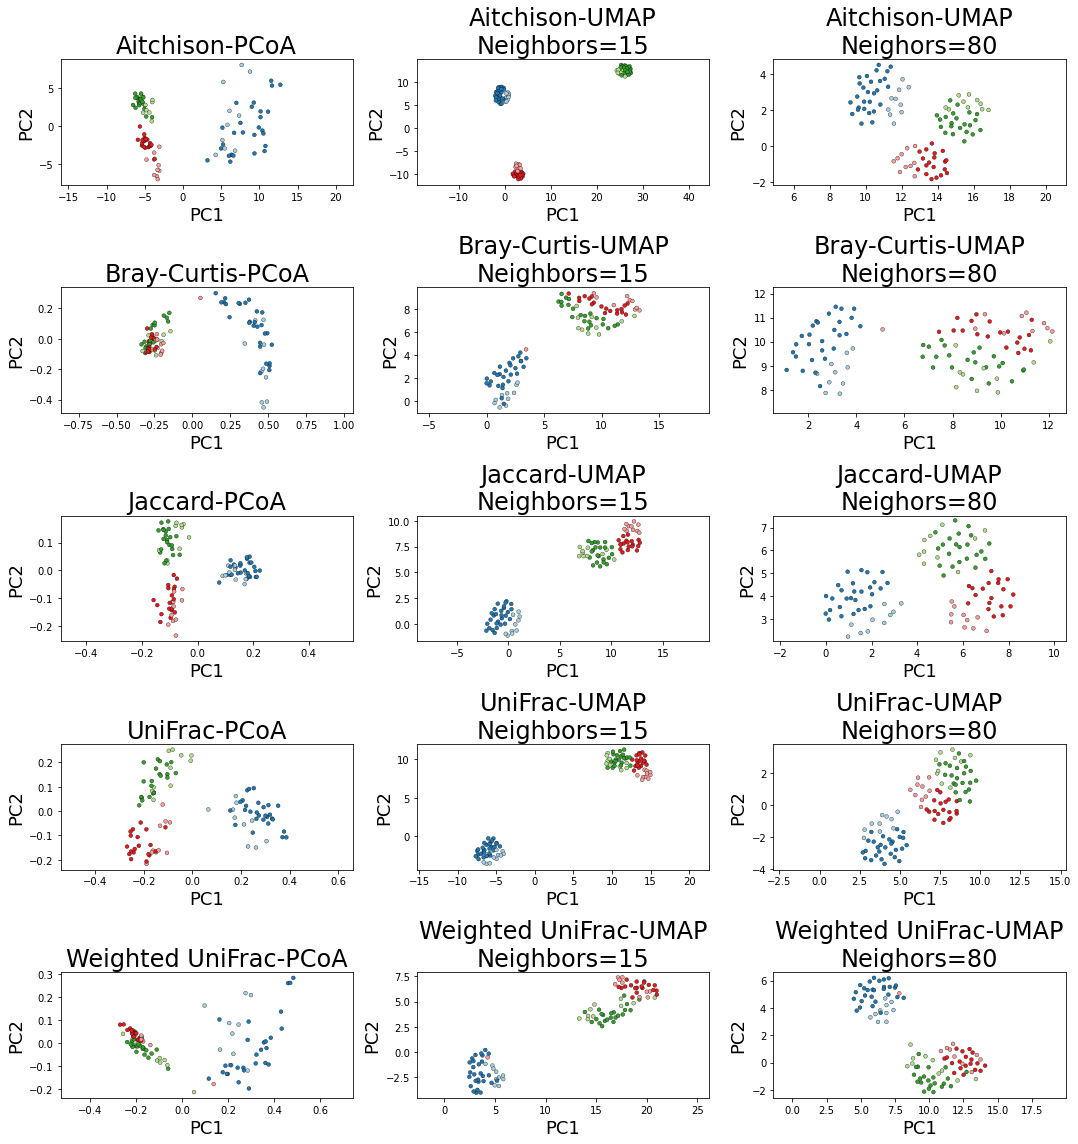

In [48]:
fig, axs = plt.subplots(len(v_position_map), len(h_position_map),
                        figsize=(15, 8 * 6 / 3),
                        )
for name, method in results:
        i = v_position_map[name]
        j = h_position_map[method]
        res = results[(name, method)]
        res.index = metadata.index
        res = res.join(metadata)

        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue='host_surface',
            hue_order=list(sorted(metadata['host_surface'].unique())),
            # style='sample_type',
            data=res,
            ax=axs[i][j],
            s=15,
            edgecolor='k',
            palette='Paired',
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)

        g.set_xlabel('PC1', color='black', fontsize=18)
        g.set_ylabel('PC2', color='black', fontsize=18),

plt.tight_layout()
plt.savefig('results/2.0-real-data-keyboard-ordination.png', dpi=300)
plt.show()